# Noise2Self for Neural Nets

This is a simple notebook demonstrating the principle of using self-supervision to train denoising networks.

For didactic purposes, we use a simple dataset (Gaussian noise on MNIST), a simple model (a small UNet), and a short training (100 iterations on a CPU). This notebook runs on a MacBook Pro in under one minute.

In [1]:
import sys
sys.path.append("..")

In [2]:
from util import show, plot_images, plot_tensors

# Data

We demonstrate the use of a self-supervised denoising objective on a synthetically noised version of MNIST.

In [3]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Dataset

mnist_train = MNIST('../data/MNIST', download = True,
                    transform = transforms.Compose([
                        transforms.ToTensor(),
                    ]), train = True)

mnist_test = MNIST('../data/MNIST', download = True,
                    transform = transforms.Compose([
                        transforms.ToTensor(),
                    ]), train = False)

In [4]:
from torch import randn
def add_noise(img):
    return img + randn(img.size())*0.4

class SyntheticNoiseDataset(Dataset):
    def __init__(self, data, mode='train'):
        self.mode = mode
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img = self.data[index][0]
        return add_noise(img), img

In [5]:
noisy_mnist_train = SyntheticNoiseDataset(mnist_train, 'train')
noisy_mnist_test = SyntheticNoiseDataset(mnist_test, 'test')

We will try to learn to predict the clean image on the right from the noisy image on the left.

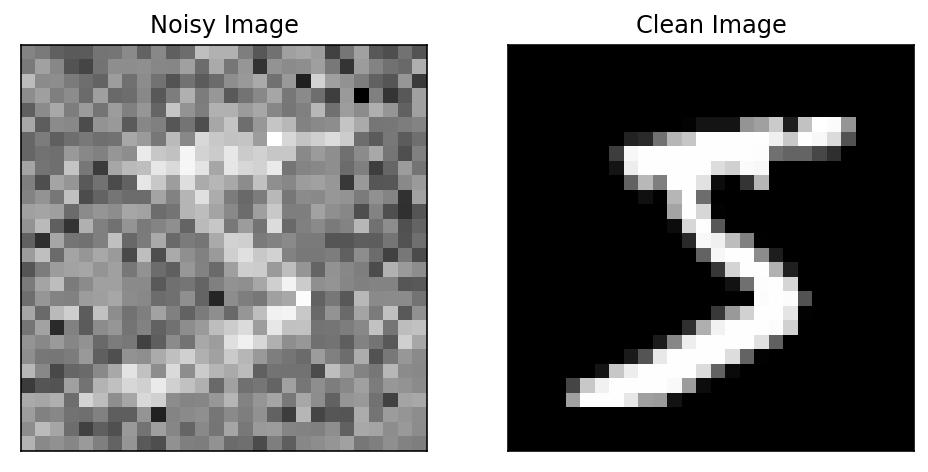

In [6]:
noisy, clean = noisy_mnist_train[0]
plot_tensors([noisy[0], clean[0]], ['Noisy Image', 'Clean Image'])

# Masking

The strategy is to train a $J$-invariant version of a neural net by replacing a grid of pixels with the average of their neighbors, then only evaluating the model on the masked pixels.

In [7]:
from mask import Masker
masker = Masker(width = 4, mode='interpolate')

In [8]:
net_input, mask = masker.mask(noisy.unsqueeze(0), 0)

A mask; the data; the input to the neural net, which doesn't depend on the values of $x$ inside the mask; and the difference between the neural net input and $x$.

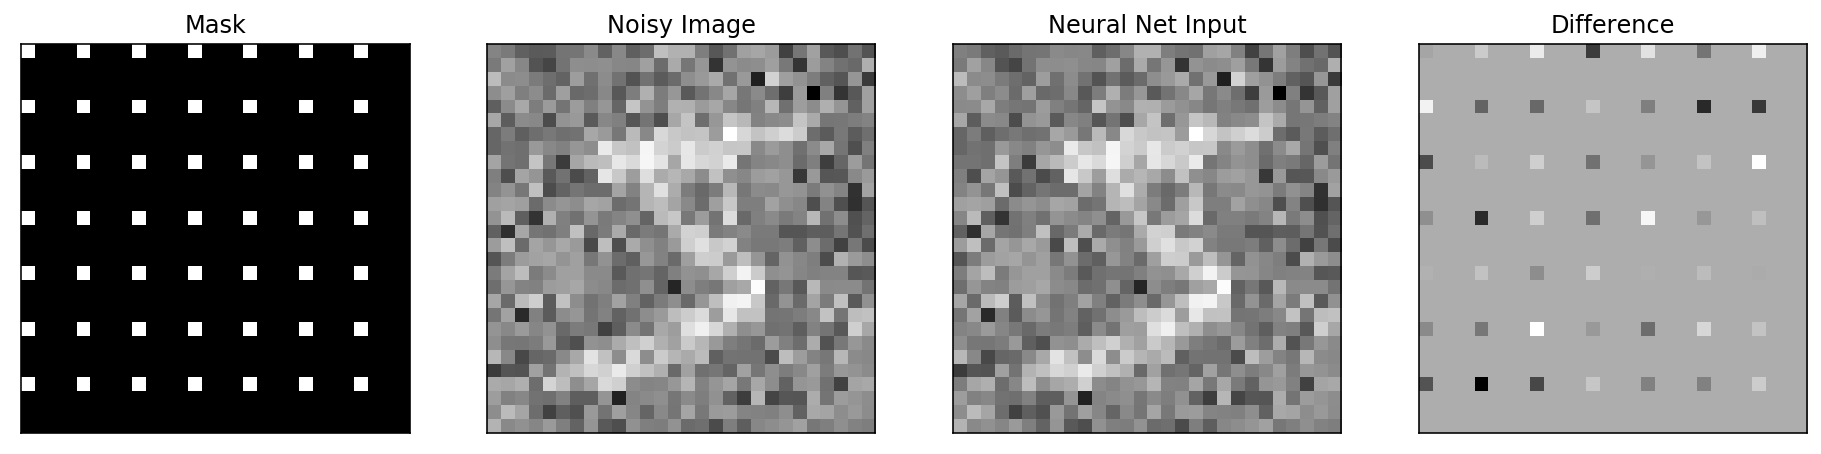

In [9]:
plot_tensors([mask, noisy[0], net_input[0], net_input[0] - noisy[0]],
            ["Mask", "Noisy Image", "Neural Net Input", "Difference"])

# Model

For our model, we use a short UNet with two levels of up- and down- sampling

In [10]:
from models.babyunet import BabyUnet
model = BabyUnet()

# Training

In [11]:
from torch.nn import MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader

loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [12]:
data_loader = DataLoader(noisy_mnist_train, batch_size=32, shuffle=True)

for i, batch in enumerate(data_loader):
    noisy_images, clean_images = batch
    
    net_input, mask = masker.mask(noisy_images, i)
    net_output = model(net_input)
    
    loss = loss_function(net_output*mask, noisy_images*mask)
    
    optimizer.zero_grad()
 
    loss.backward()
    
    optimizer.step()
    
    if i % 10 == 0:
        print("Loss (", i, "): \t", round(loss.item(), 4))
        
    if i == 100:
        break

Loss ( 0 ): 	 0.0893
Loss ( 10 ): 	 0.0264
Loss ( 20 ): 	 0.0243
Loss ( 30 ): 	 0.016
Loss ( 40 ): 	 0.0167
Loss ( 50 ): 	 0.0159
Loss ( 60 ): 	 0.0141
Loss ( 70 ): 	 0.0134
Loss ( 80 ): 	 0.0134
Loss ( 90 ): 	 0.0122
Loss ( 100 ): 	 0.0124


In [13]:
test_data_loader = DataLoader(noisy_mnist_test,
                                              batch_size=32,
                                              shuffle=False,
                                              num_workers=3)
i, test_batch = next(enumerate(test_data_loader))
noisy, clean = test_batch

With our trained model, we have a choice. We may do a full $J$-invariant reconstruction, or we may just run the noisy data through the network unaltered.

In [14]:
simple_output = model(noisy)
invariant_output = masker.infer_full_image(noisy, model)

In [15]:
type(simple_output)

torch.Tensor

In [16]:
np.asarray(simple_output)

RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

`torch.Tensor.__array__` is hampered because the developers want to prevent accidentally dropping gradient. See:

https://discuss.pytorch.org/t/should-it-really-be-necessary-to-do-var-detach-cpu-numpy/35489

For demo purposes, we increase the magic of torch Tensors.

In [17]:
import torch

In [18]:
def array(self, dtype=None):
    if dtype is None:
        return self.detach().numpy()
    else:
        return self.detach().numpy().astype(dtype, copy=False)

torch.Tensor.__array__ = array

In [19]:
np.array(simple_output)

array([[[[-0.04271331,  0.0083861 , -0.00043166, ..., -0.19075006,
          -0.14270361,  0.00689206],
         [ 0.0385207 ,  0.12935059,  0.07894244, ..., -0.15526037,
          -0.1227105 , -0.06203396],
         [ 0.03028552,  0.12735972,  0.10934486, ..., -0.14969152,
          -0.14621755, -0.11785081],
         ...,
         [ 0.14075962,  0.11371569,  0.01463523, ...,  0.03280801,
           0.01231988,  0.14723638],
         [ 0.20538658,  0.19669619,  0.10946525, ..., -0.13679062,
          -0.10313954,  0.17042972],
         [ 0.22676057,  0.17630967,  0.0960146 , ..., -0.01484951,
          -0.0225734 ,  0.14118099]]],


       [[[-0.09408123, -0.048458  , -0.15165146, ...,  0.00236629,
           0.1893445 ,  0.29405597],
         [-0.05361651, -0.00634312, -0.0913252 , ...,  0.04921016,
           0.19229575,  0.20516661],
         [-0.09397998, -0.00820459, -0.06335477, ...,  0.00355111,
           0.07617597,  0.04709059],
         ...,
         [ 0.08911725, -0.005948

In [20]:
%gui qt

In [21]:
import napari

viewer = napari.Viewer()

viewer.add_image(
    noisy, name='noisy',
    contrast_limits=[-1.5, 2.5],
)
viewer.add_image(
    simple_output, name='simple output',
    contrast_limits=[-0.5, 1.5],
)
viewer.add_image(
    invariant_output, name='j-invariant output',
    contrast_limits=[-0.5, 1.5],
)

<Image layer 'j-invariant output' at 0x177be9290>

While both the simple and invariant output are significantly denoised, the invariant output has a mild pixelation. 

This is due to the fact that neighboring pixels are denoised using different information, leading to discontinuities in the reconstructed output.